# We saw that for CTCF CUT&RUN (profile head), the TA motif was less common in the multi-task model than the single-task model; why is that?
## What do the motif hit counts look like?

In [1]:
import os
os.chdir('/home/katie/bp_repo/reports/')

from util import import_shap_scores, import_peak_table, import_profiles, import_tfmodisco_results
from util import trim_motif_by_ic
from util import figure_to_vdom_image
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from IPython.display import display
import tqdm
tqdm.tqdm_notebook()

plt.rcParams["figure.dpi"] = 130

/tmp/ipykernel_63940/1013105652.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

In [2]:
# CTCF multi-task cutnrun motif hits

# Define parameters/fetch arguments
hits_single = ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_cutnrun_feb7/tfm_matches.bed']
print("Single-task motif hits path: %s" % hits_single)

hits_max = ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed']
print("SHORT motif hits path: %s" % hits_max)

hits_min = ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed']
print("LONG motif hits path: %s" % hits_min)

Single-task motif hits path: ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_cutnrun_feb7/tfm_matches.bed']
SHORT motif hits path: ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed']
LONG motif hits path: ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed']


In [3]:
# Import motif hits
hits_single = import_peak_table(hits_single)    # 141,551 hits and peak lengths are 17 or 8
hits_max = import_peak_table(hits_max)          # 295,274 hits and peak lengths are 8, 13, 25, 23, 19, or 22
hits_min = import_peak_table(hits_min)          # 295,135 hits and peak lengths are 7, 18, 24, or 25

Text(0.5, 1.0, 'Motif hit counts: single-task CUT&RUN')

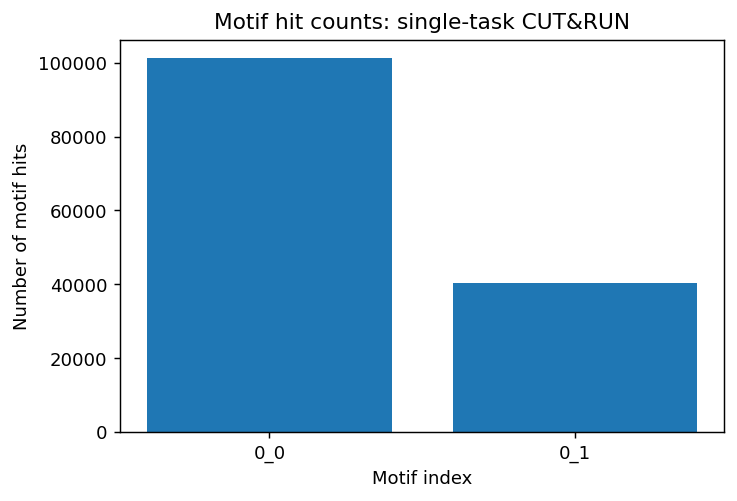

In [4]:
# motif hit counts bar plot for SINGLE task
plt.bar(pd.value_counts(hits_single.name).keys(), pd.value_counts(hits_single.name).values)
plt.xlabel('Motif index')
plt.ylabel('Number of motif hits')
plt.title('Motif hit counts: single-task CUT&RUN')

Text(0.5, 1.0, 'Motif hit counts: short task from multi-task CUT&RUN')

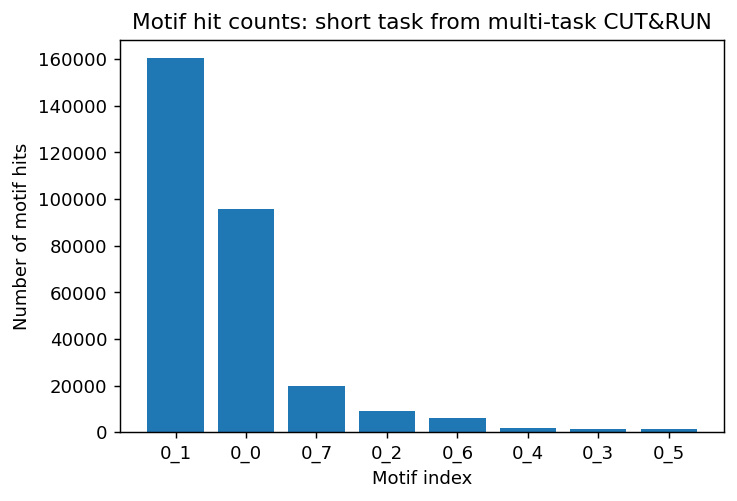

In [5]:
# motif hit counts bar plot for MAX task
fig = plt.plot(dpi=2000)
plt.bar(pd.value_counts(hits_max.name).keys(), pd.value_counts(hits_max.name).values)
plt.xlabel('Motif index')
plt.ylabel('Number of motif hits')
plt.title('Motif hit counts: short task from multi-task CUT&RUN')

In [ ]:
# motif hit counts bar plot for MIN task
plt.bar(pd.value_counts(hits_min.name).keys(), pd.value_counts(hits_min.name).values)
plt.xlabel('Motif index')
plt.ylabel('Number of motif hits')
plt.title('Motif hit counts: long task from multi-task CUT&RUN')

# Find a few locations where long or short task finds TA motif, but single task doesn’t. Show importance scores for these 3 tasks and the observed/predicted profiles.
## extra task after meeting Feb 9, 2022

#### BACK TO THE BASICS MARCH 8 

In [6]:
# Plotting defaults
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

# Import the set of peaks
peak_table = import_peak_table(['/home/katie/bp_repo/research/data/cutnrun/CTCF/CTCF.bed'])

# Define constants
input_length, profile_length = 2114, 1000
shap_score_center_size = 400
profile_display_center_size = 400
hyp_score_key = "hyp_scores"

shap_scores_path_short, shap_scores_path_long, shap_scores_path_single = '/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_120_150_feb7/shap_scores_CTCF_120','/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_120_150_feb7/shap_scores_CTCF_150', '/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_feb7/shap_scores'


In [3]:
# THE COORDS FOR THE SHAP AND PREDS HDF5s ARE THE  * S A M E *  YES I CHECKED!


# Import SHAP coordinates and one-hot sequences
# EXACTLY SAME AS IMPORTING THE ORIGINAL HDF5 FROM PIPELINE_OUTPUTS   YES I CHECKED
# EXCEPT THIS CUTS THE CENTER TO THE 400 BP WE ARE USED TO
hyp_scores_short, _, one_hot_seqs_short, shap_coords_short = import_shap_scores(shap_scores_path_short, hyp_score_key, 
                                                              center_cut_size=shap_score_center_size, remove_non_acgt=False)
hyp_scores_long, _, one_hot_seqs_long, shap_coords_long = import_shap_scores(shap_scores_path_long, hyp_score_key, 
                                                              center_cut_size=shap_score_center_size, remove_non_acgt=False)
hyp_scores_single, _, one_hot_seqs_single, shap_coords_single = import_shap_scores(shap_scores_path_single, hyp_score_key, 
                                                              center_cut_size=shap_score_center_size, remove_non_acgt=False)
# This cuts the sequences/scores off just as how TF-MoDISco saw them, but the coordinates are uncut

# Import the set of all profiles and their coordinates
# EXACTLY SAME AS IMPORTING THE ORIGINAL HDF5 FROM PIPELINE_OUTPUTS   YES I CHECKED
true_profs_multi, pred_profs_multi, all_pred_coords_multi = import_profiles('/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_120_150_feb7/preds')
true_profs_single, pred_profs_single, all_pred_coords_single = import_profiles('/home/katie/bp_repo/pipeline_outputs/ctcf_cutnrun_feb7/preds')

# each len is 4 * 54227 where 54227 is num of cut&run peaks
# if you drop_duplicates, you get exactly 54227 rows. each CORRESPONDS to the row in peak table but not in order??




Importing SHAP scores: 100%|██████████████████| 217/217 [00:03<00:00, 55.38it/s]

Importing SHAP scores: 100%|██████████████████| 109/109 [00:01<00:00, 56.62it/s]


Importing predictions:   0%|          | 0/217 [00:00<?, ?it/s]

Importing predictions:   0%|          | 0/109 [00:00<?, ?it/s]

In [5]:
all_pred_coords_single_df = pd.DataFrame(all_pred_coords_single, columns=['chrom','peak_start','peak_end'])
all_pred_coords_multi_df = pd.DataFrame(all_pred_coords_multi, columns=['chrom','peak_start','peak_end'])

In [6]:
# if you drop duplicates of all_pred_coords_single_df or short  (or the all_pred_coords_table stuff) then you can INDEX BY PEAK!!
# same for dropping duplicates of the shap_coords_short/long/single (if you convert to df first)
np.array_equal(np.array(all_pred_coords_multi_df.drop_duplicates().chrom), np.array(peak_table.loc[peak_table.chrom != 'chrM'].chrom))

True

In [67]:
def check_validity(hit, proposed_peak):
    ''' determine if a motif hit lies inside a proposed set of coords (chrom/start/end) '''
    if isinstance(proposed_peak, pd.core.frame.DataFrame) or isinstance(proposed_peak, pd.core.series.Series):
        return (hit.peak_start >= proposed_peak.peak_start) and (hit.peak_end <= proposed_peak.peak_end) and (hit.chrom == proposed_peak.chrom)
    elif isinstance(proposed_peak, np.ndarray):
        return ((hit.peak_start >= proposed_peak[1]) and (hit.peak_end <= proposed_peak[2]) and (hit.chrom == proposed_peak[0]))
    else:
        return 'what da heck is this you moron ????'


In [8]:
# find motif hits unique to long/short task, where single-task doesn't see importance
#os.system('bedtools intersect -v -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed -b /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_cutnrun_feb7/tfm_matches.bed > /home/katie/bp_repo/reports/katie_notebooks/TASK_1/unique_short_no_single')
#os.system('bedtools intersect -v -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed -b /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_cutnrun_feb7/tfm_matches.bed > /home/katie/bp_repo/reports/katie_notebooks/TASK_1/unique_long_no_single')

short_unique_hits = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/TASK_1/unique_short_no_single']) # 161,418 hits
long_unique_hits = import_peak_table(['/home/katie/bp_repo/reports/katie_notebooks/TASK_1/unique_long_no_single'])   # 155,922 hits

# so about half of the hits for both short and long tasks are unique to them and don't overlap single-task hits
# but it is NOT true that every single-task hit overlaps a short/long hit, if you compare the numbers of motif hits 


In [11]:
# subset to TA motif hits
TA_hits_max = hits_max.loc[hits_max.name == '0_1']  # len 160,414
TA_hits_min = hits_min.loc[hits_min.name == '0_1']  # len 179,126
TA_hits_single = hits_single.loc[hits_single.name == '0_1']  # len 40,332

TA_hits_max_no_single = short_unique_hits.loc[short_unique_hits.name == '0_1']  # len 114,501
TA_hits_min_no_single = long_unique_hits.loc[long_unique_hits.name == '0_1']  # len 128,450

#### Notes: 
* true_profs, pred_profs, all_pred_coords: each len is 2 * or 4 * 54227 where 54227 is num of cut&run peaks
    * if you drop_duplicates, you get exactly 54227 rows. each CORRESPONDS to the row in peak table but is an EXTENDED TO 2114 VERSION of peak
* ^^ same with shap_coords_table
* subset_inds reorders original profs/coords i think

In [14]:
# find the peak indices where TA motif is found in BOTH min and max and NOT IN SINGLE
peak_indices_minmax = set(TA_hits_min.strand.unique()).intersection(set(TA_hits_max.strand.unique()))
peak_indices_not_in_single = peak_indices_minmax - set(TA_hits_single.strand.unique())

In [15]:
rand = np.random.RandomState(20220309)
rand.choice(list(peak_indices_not_in_single), 5)

array([51101, 20478, 13569, 36118, 43653])

### Plot profiles (true and pred) and use viz_sequence to show shap scores

In [16]:
import sys
sys.path.append('/home/katie/bp_repo/research/')
import viz_sequence
from viz_sequence import plot_weights

def plot(true_profs, pred_profs, index, task, titles=True):
    fig, ax = plt.subplots(2, figsize=(15, 4))
    if titles:
        plt.suptitle(f'True profile on top. Predicted profile on bottom.\
        Task: {task}, Index: {index}')
    ax[0].plot(true_profs[0,:,0] / np.sum(true_profs[0,:,0]), color="royalblue")
    ax[0].plot(-true_profs[0,:,1] / np.sum(true_profs[0,:,1]), color="goldenrod")
    ax[1].plot(pred_profs[0,:,0], color="royalblue")
    ax[1].plot(-pred_profs[0,:,1], color="goldenrod")

In [17]:
INDEXES = [51101, 20478, 13569, 36118]  # 4 chosen where both short and long see TA but single DOES NOT

In [74]:
TA_hits_max_no_single.loc[TA_hits_max_no_single.strand == 36118]

,chrom,peak_start,peak_end,name,score,strand,signal,pval,qval,summit_offset,i0,i1,i2,i3,i4,i5,summit
111765,chr21,30434170,30434178,0_1,+,36118,0.252045,0.370781,0.025192,0.053943,0.217406,0.000497,1.000000,0.281646,0.197785,0.153481,3.043417e+07
111766,chr21,30434185,30434193,0_1,+,36118,0.652646,0.967474,0.065732,0.152651,0.336922,0.000512,1.000000,0.362342,0.420886,0.443038,3.043419e+07
111767,chr21,30434238,30434246,0_1,+,36118,0.424050,0.943319,0.064091,0.090876,0.096706,0.000205,0.978495,0.022152,0.018987,0.020570,3.043424e+07
111768,chr21,30434250,30434258,0_1,-,36118,0.194049,0.474781,0.032258,0.043822,0.106165,0.000287,0.978495,0.036392,0.018987,0.007911,3.043425e+07
111769,chr21,30434277,30434285,0_1,-,36118,0.567288,0.742487,0.050446,0.086153,0.161423,0.000122,0.978495,0.020570,0.018987,0.094937,3.043428e+07
111770,chr21,30434284,30434292,0_1,-,36118,0.945088,1.036546,0.070425,0.142017,0.194123,0.000491,1.000000,0.273734,0.172468,0.129747,3.043428e+07
111772,chr21,30434337,30434345,0_1,-,36118,0.393400,0.395984,0.026904,0.049634,0.221363,0.000424,0.978495,0.129747,0.151899,0.167722,3.043434e+07


In [77]:
all_pred_coords_single[~all_pred_coords_single_df.duplicated()][36118-6]

array(['chr21', 30433292, 30435406], dtype=object)

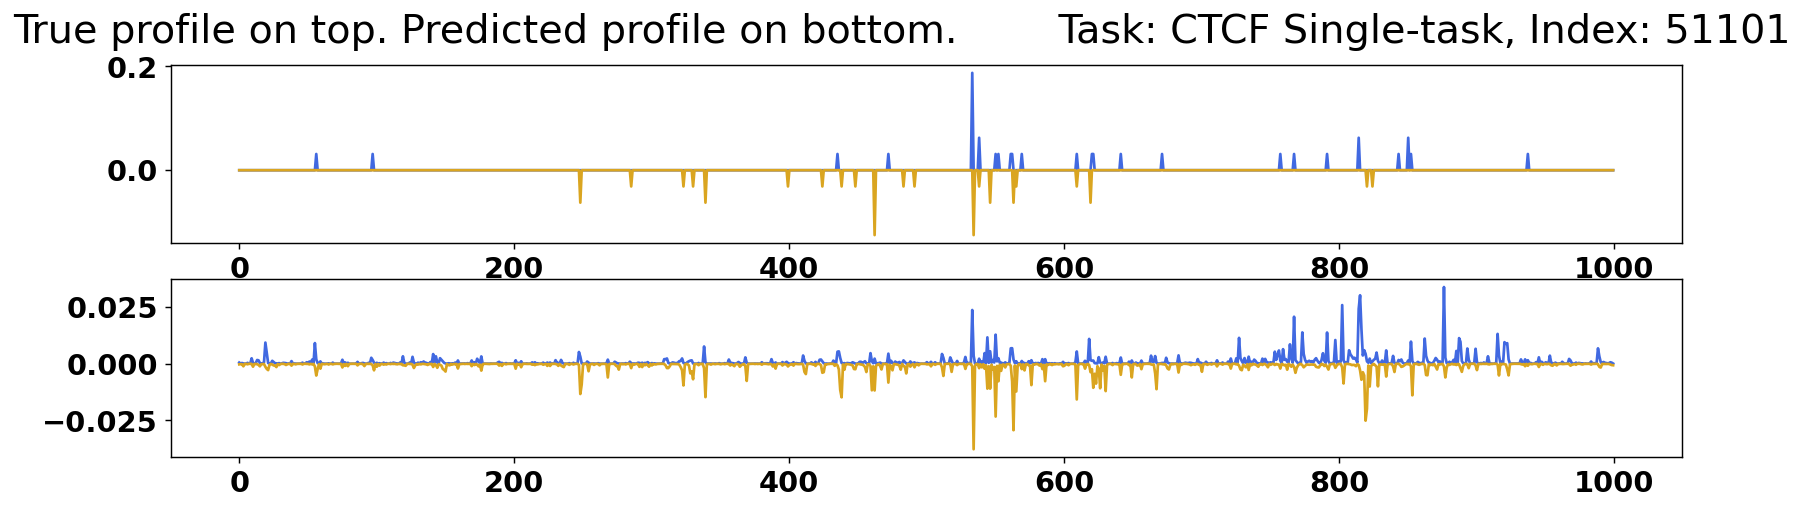

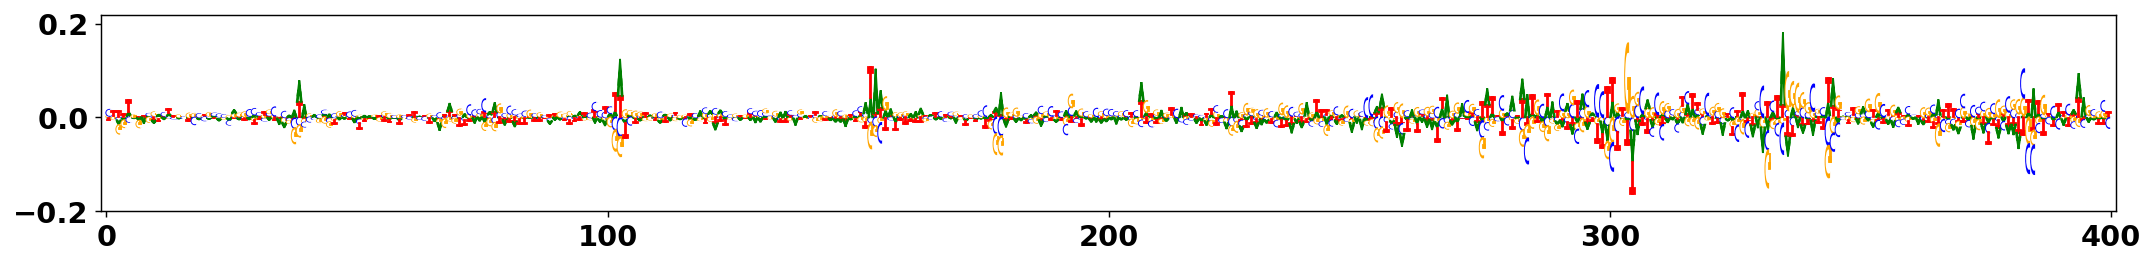

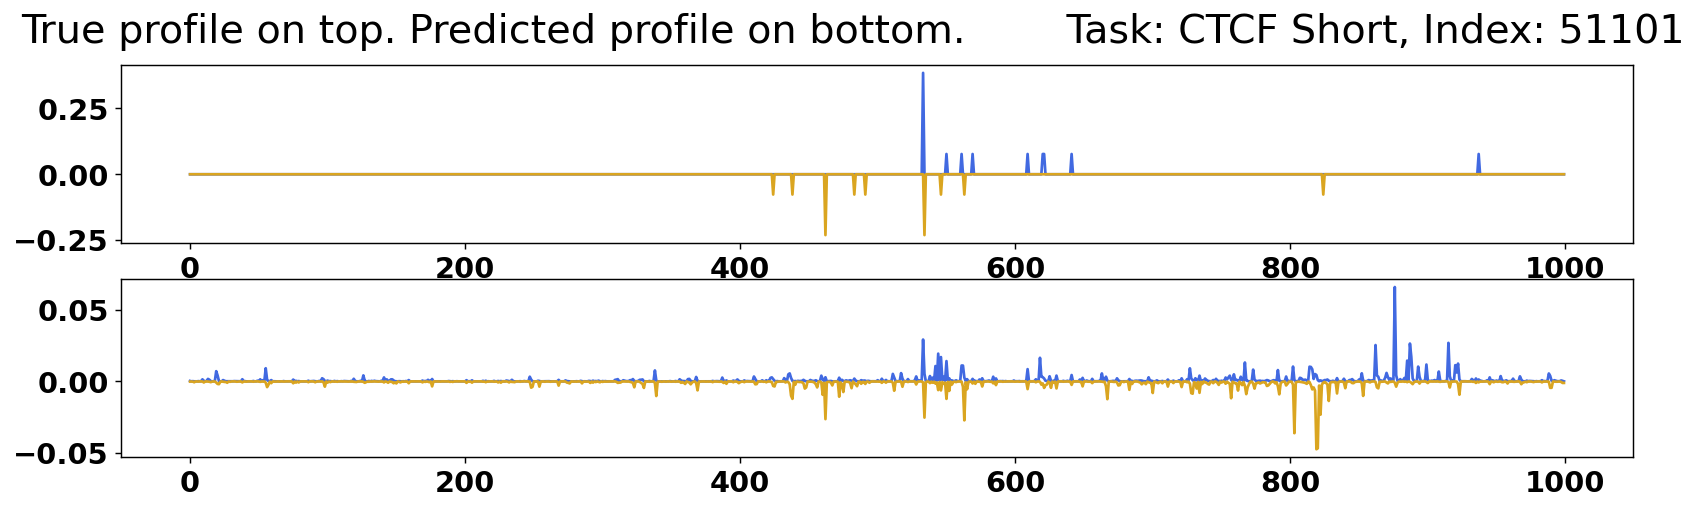

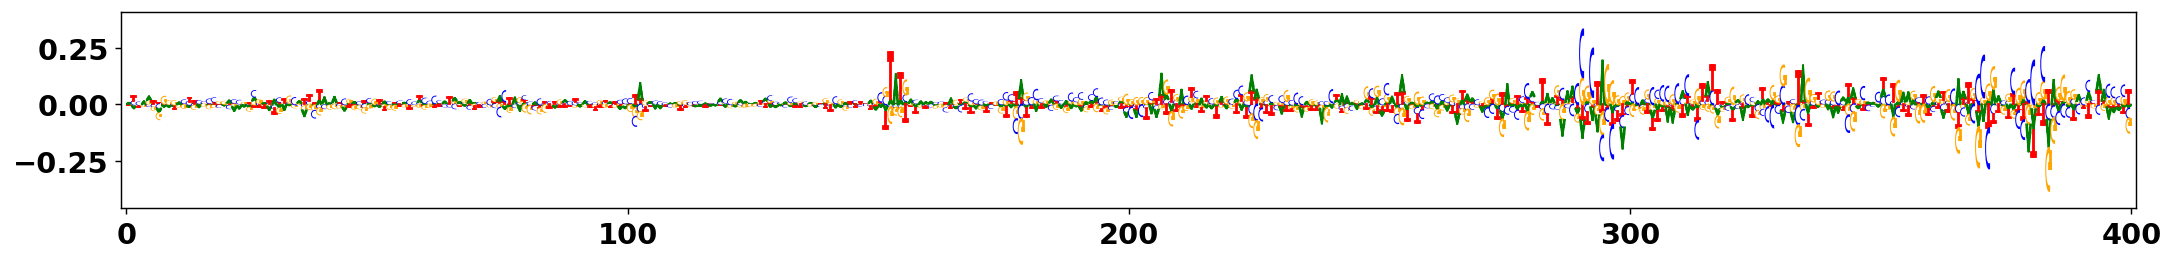

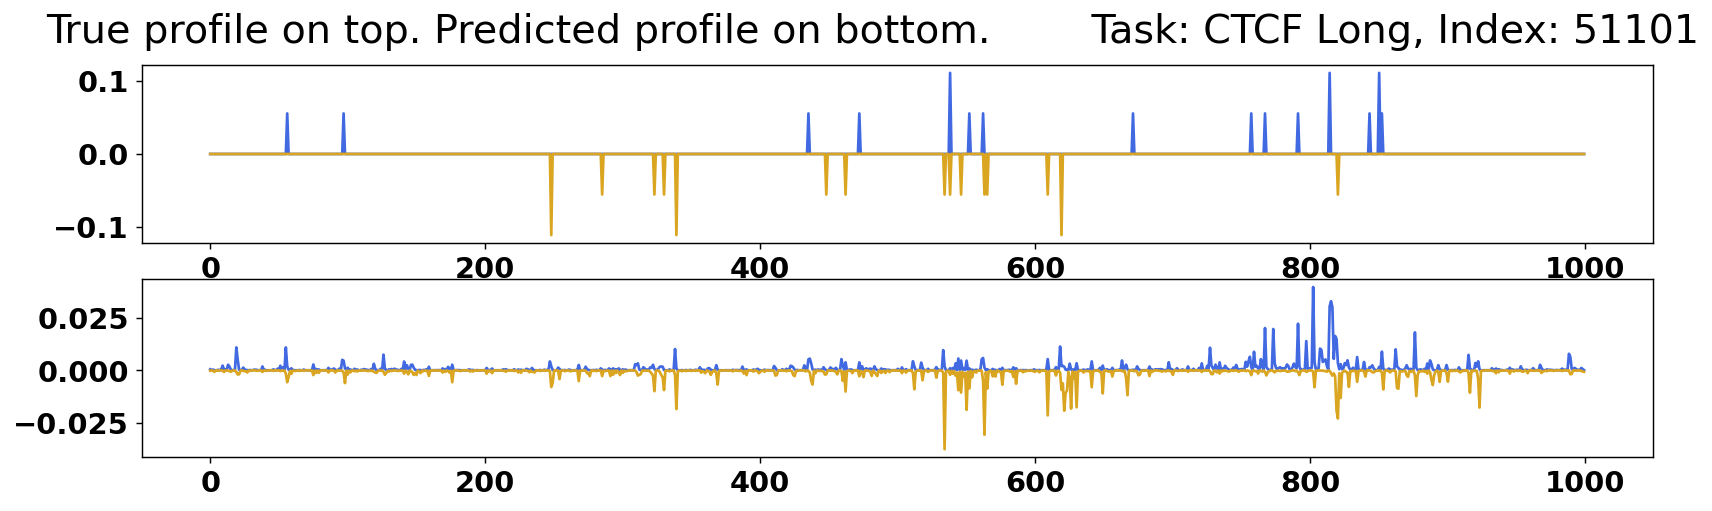

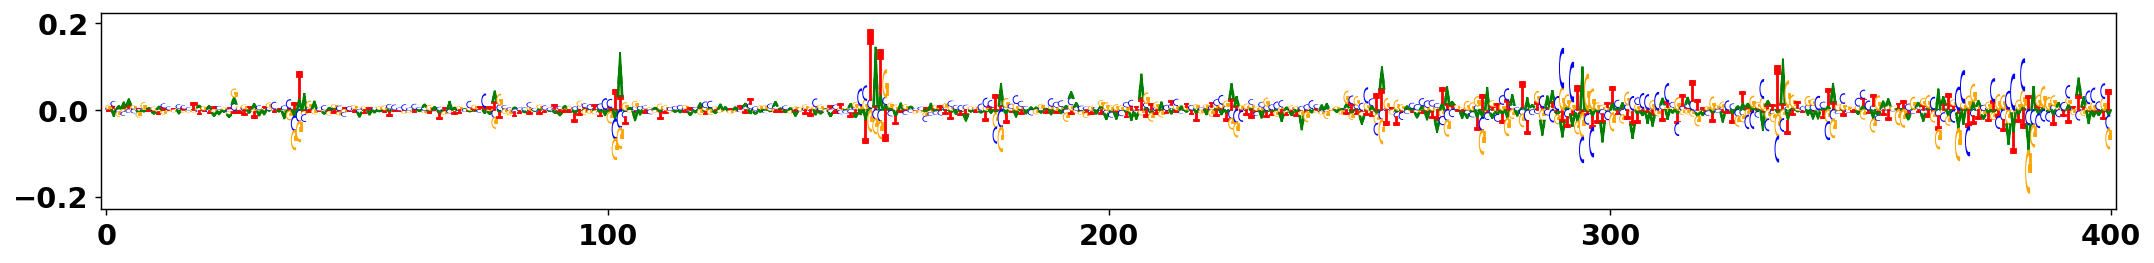

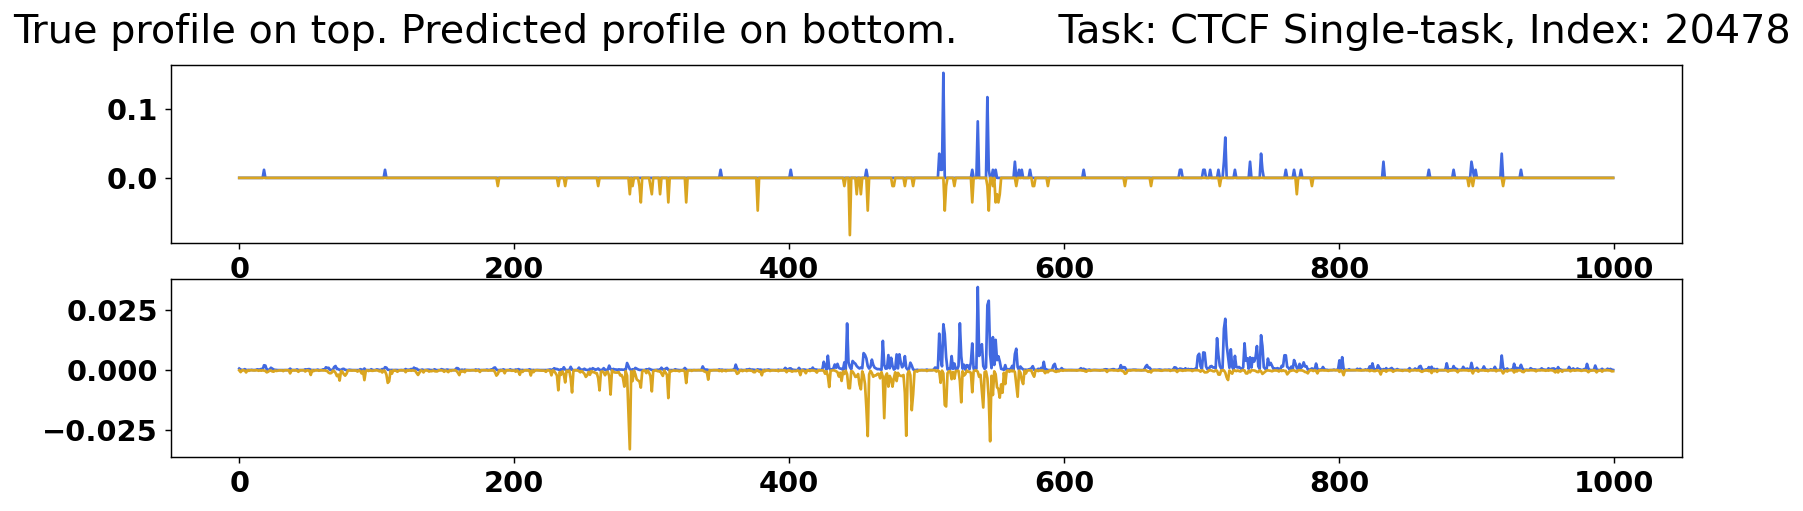

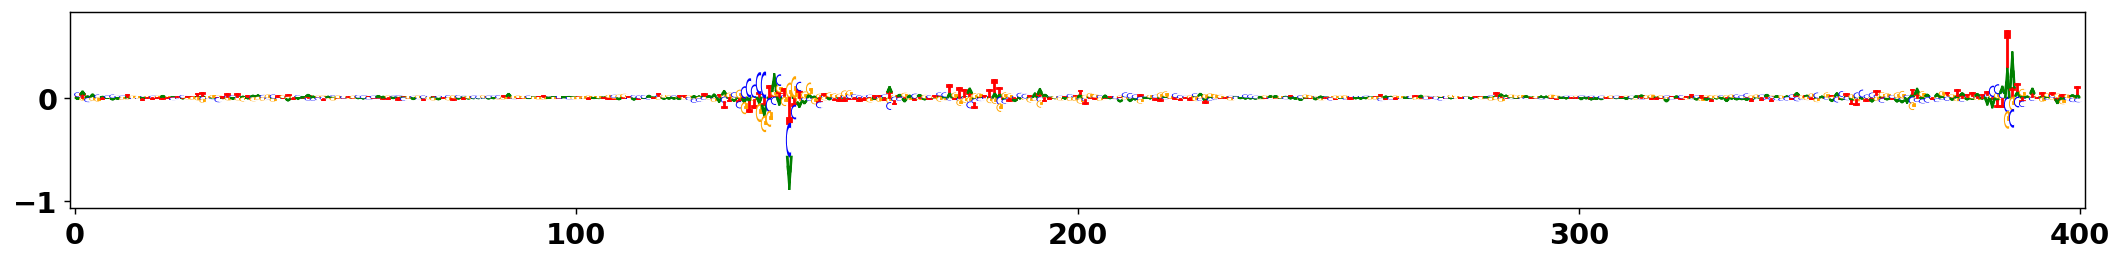

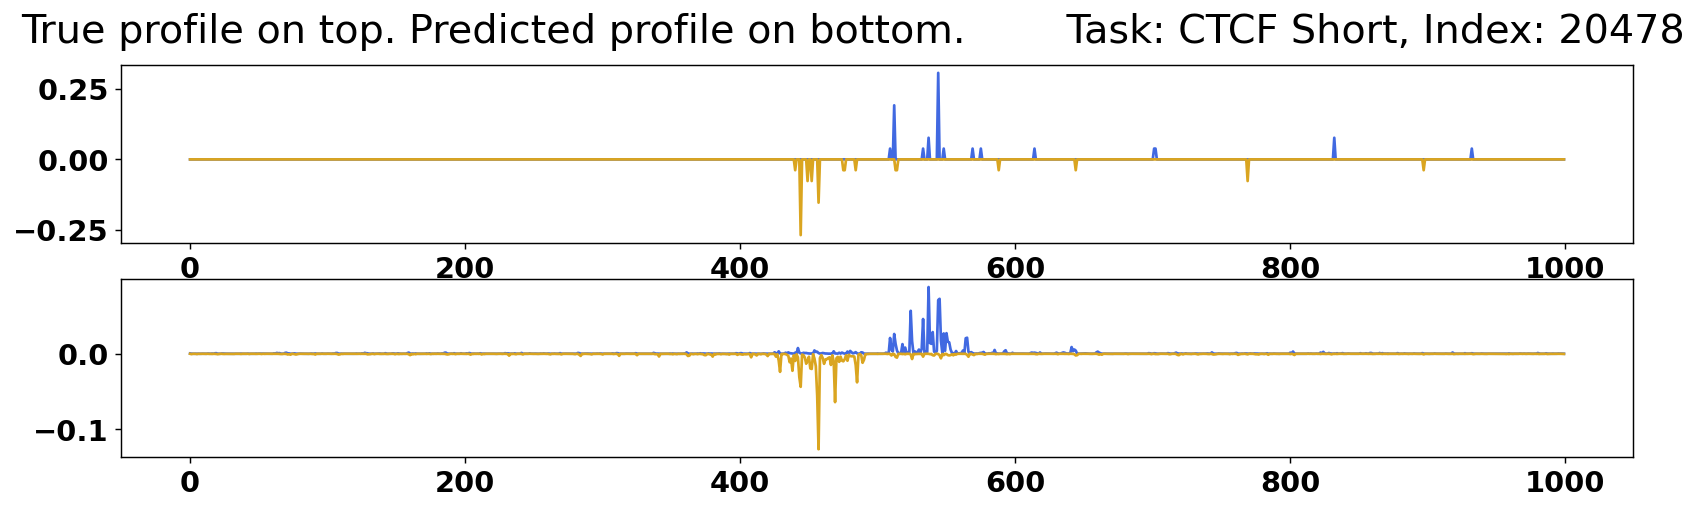

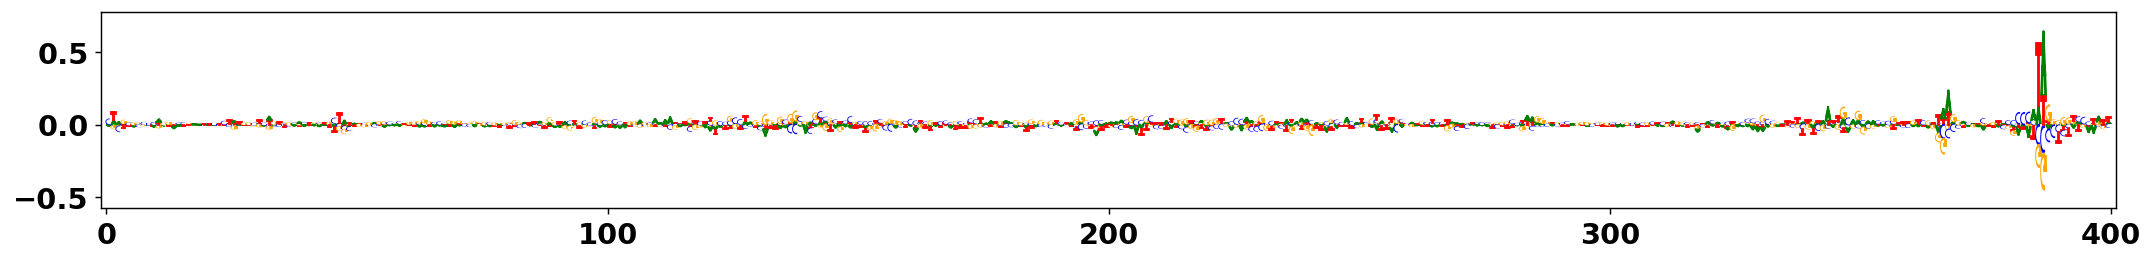

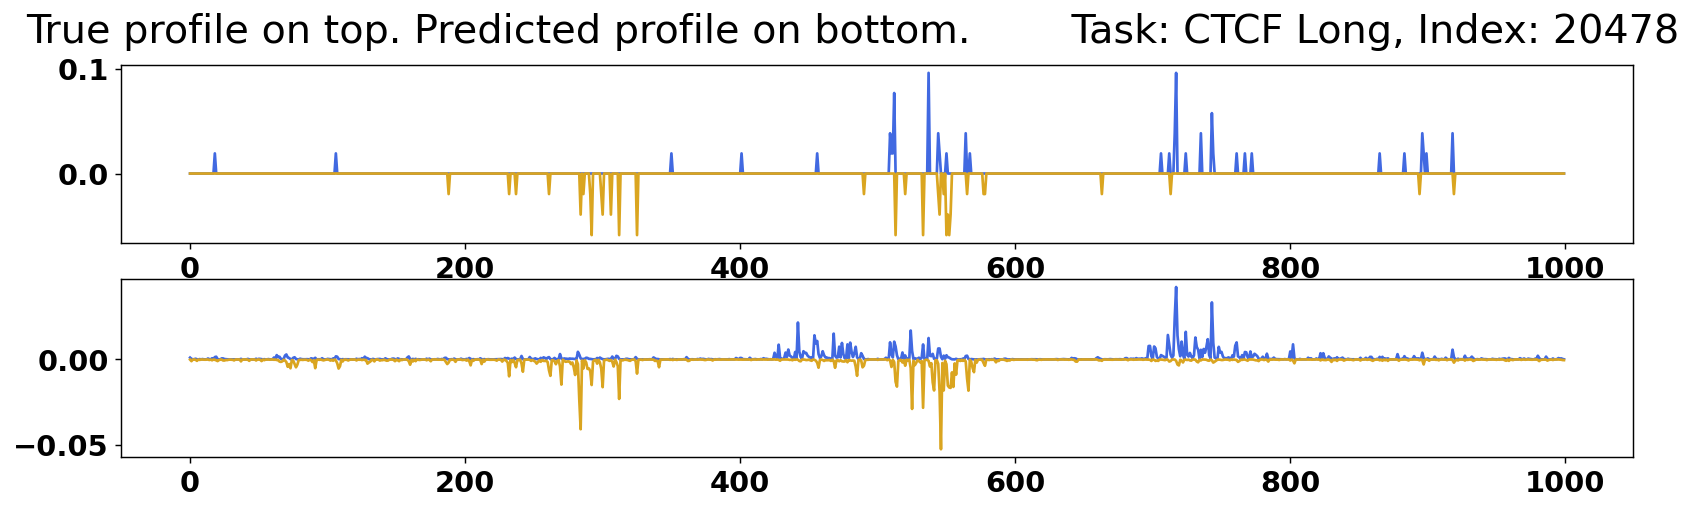

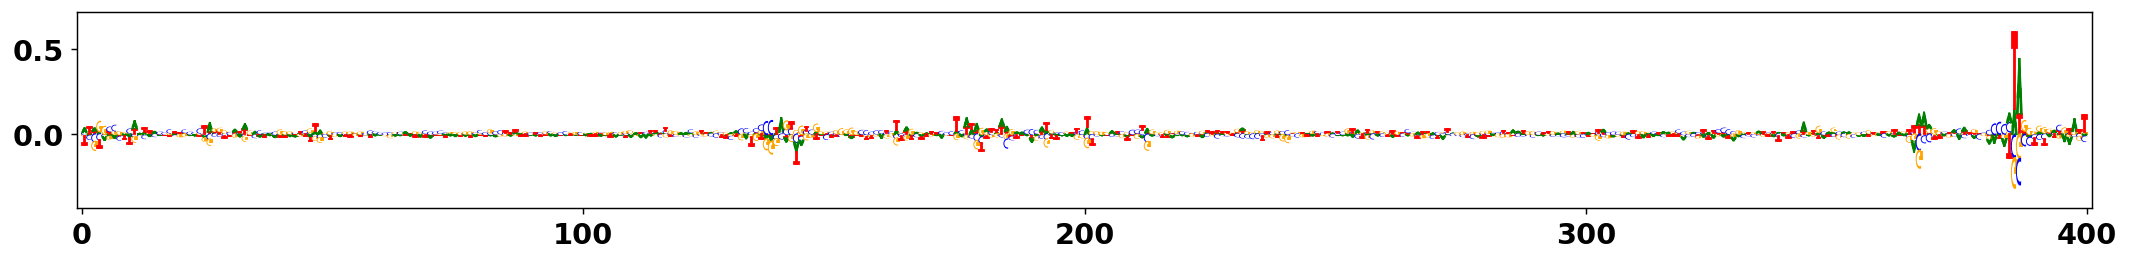

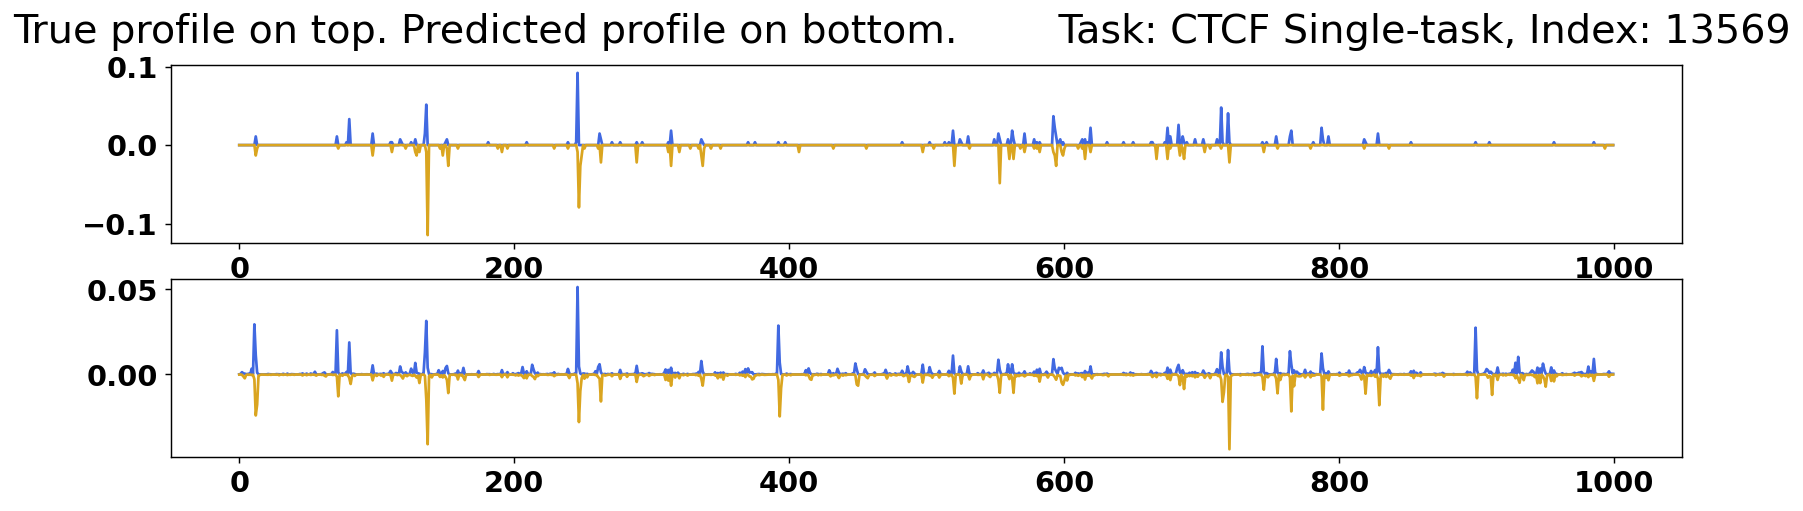

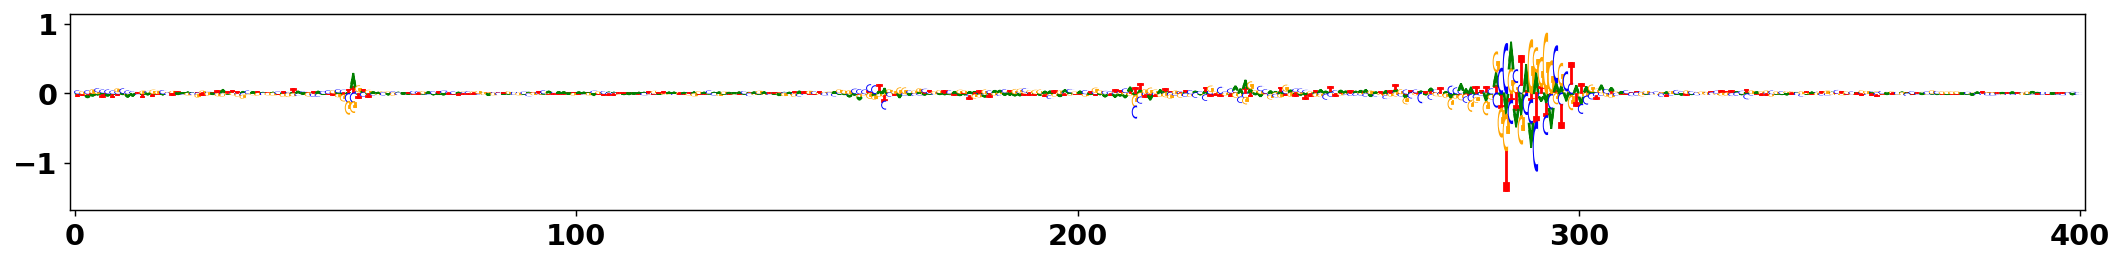

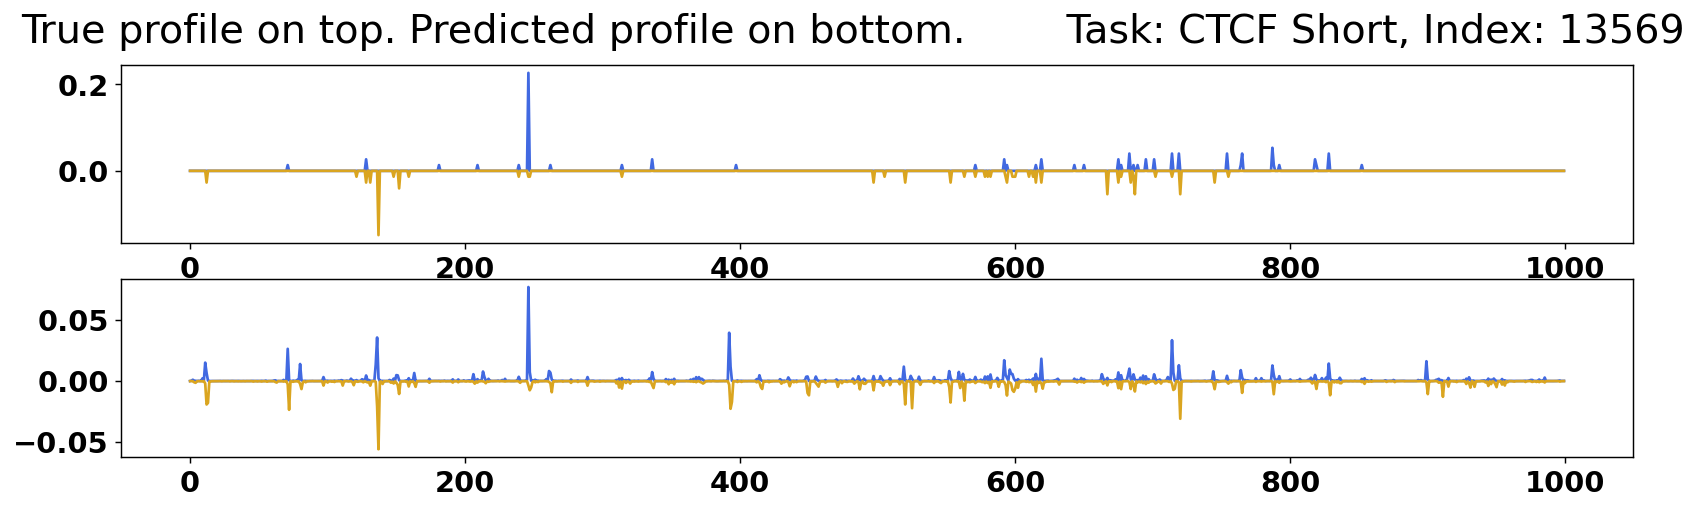

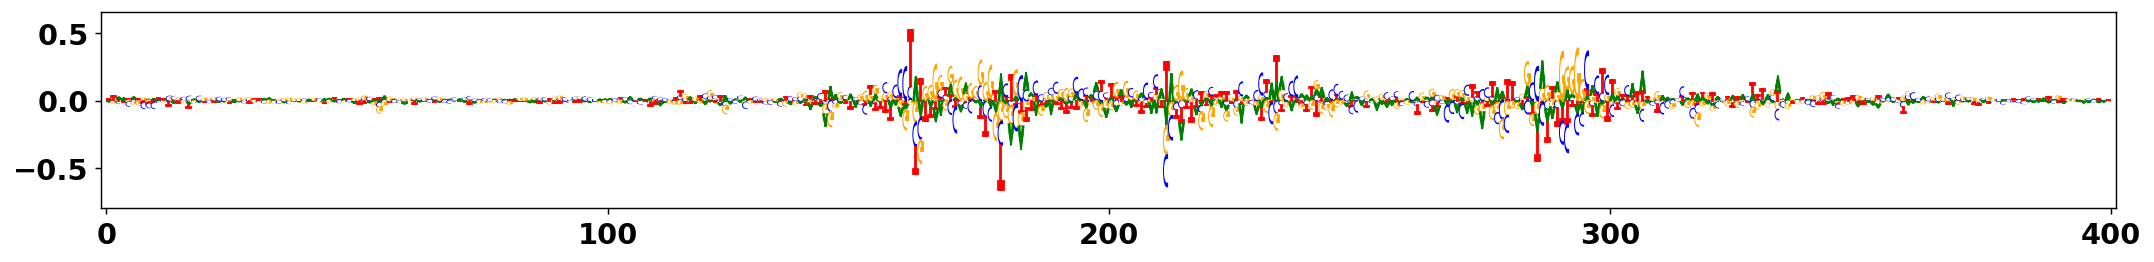

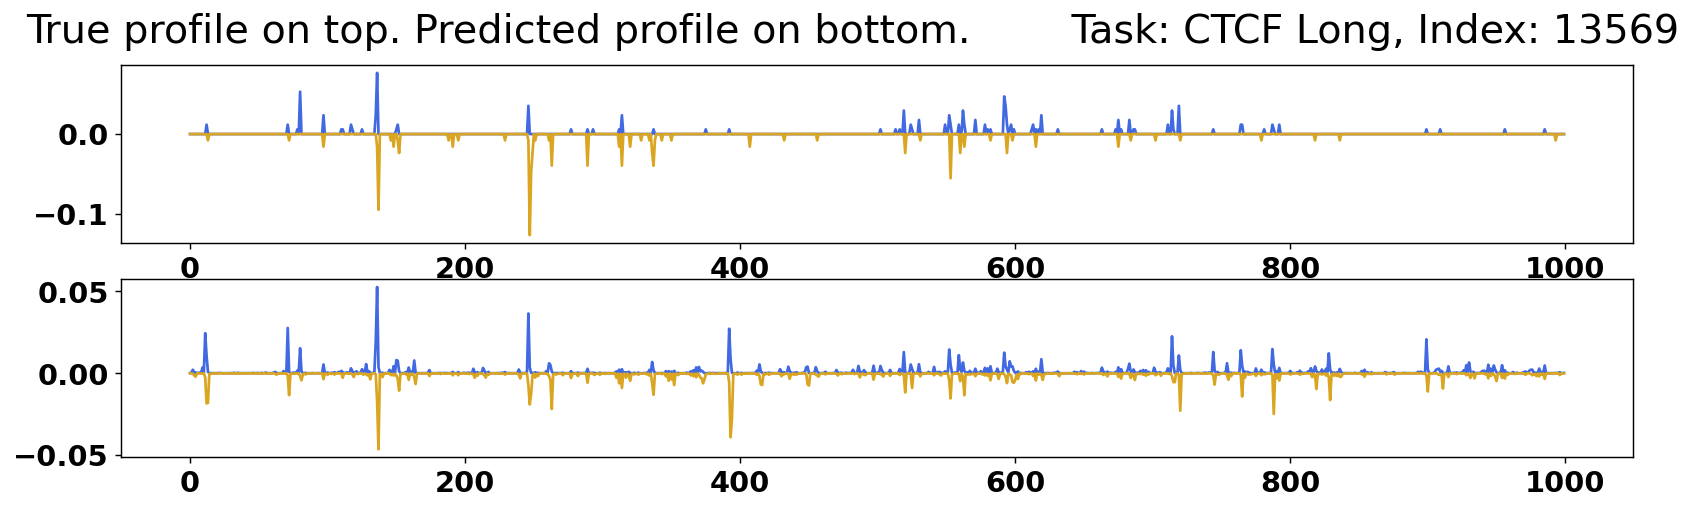

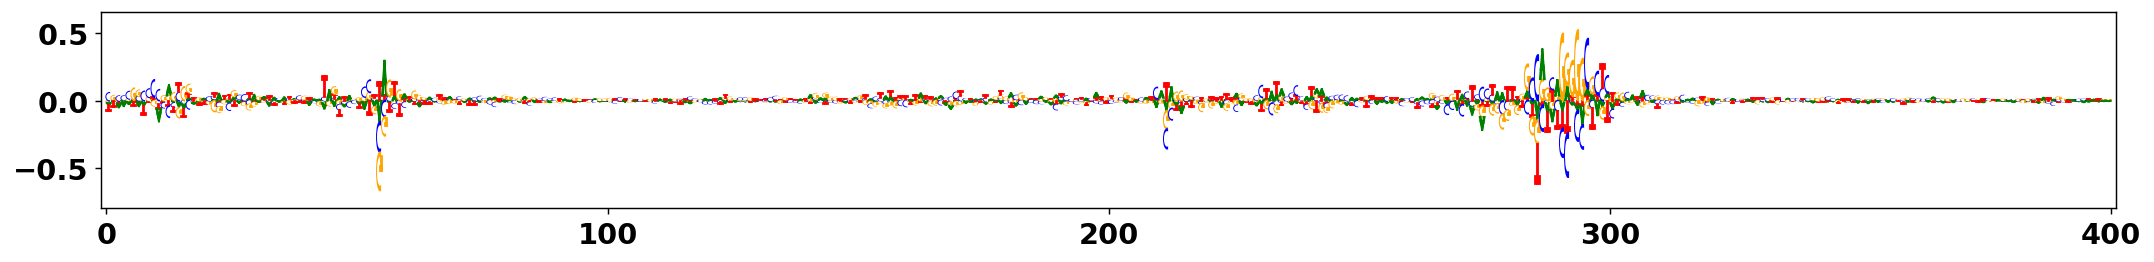

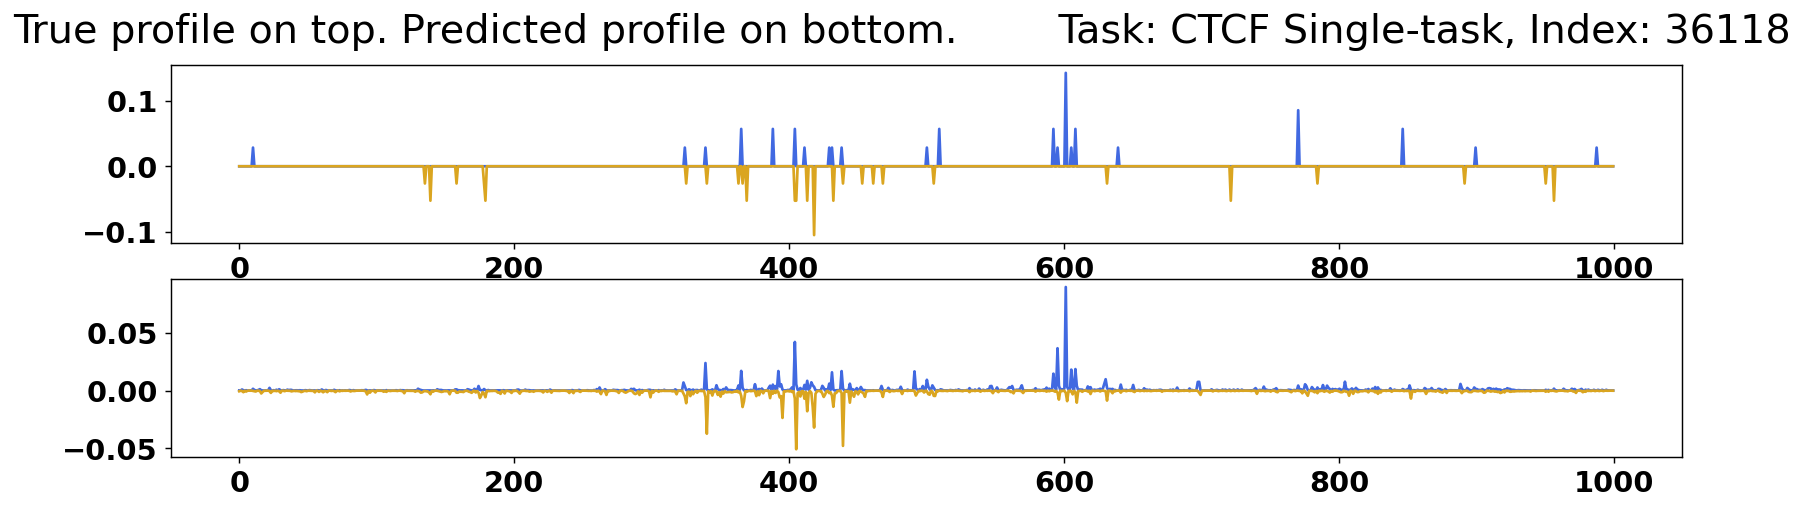

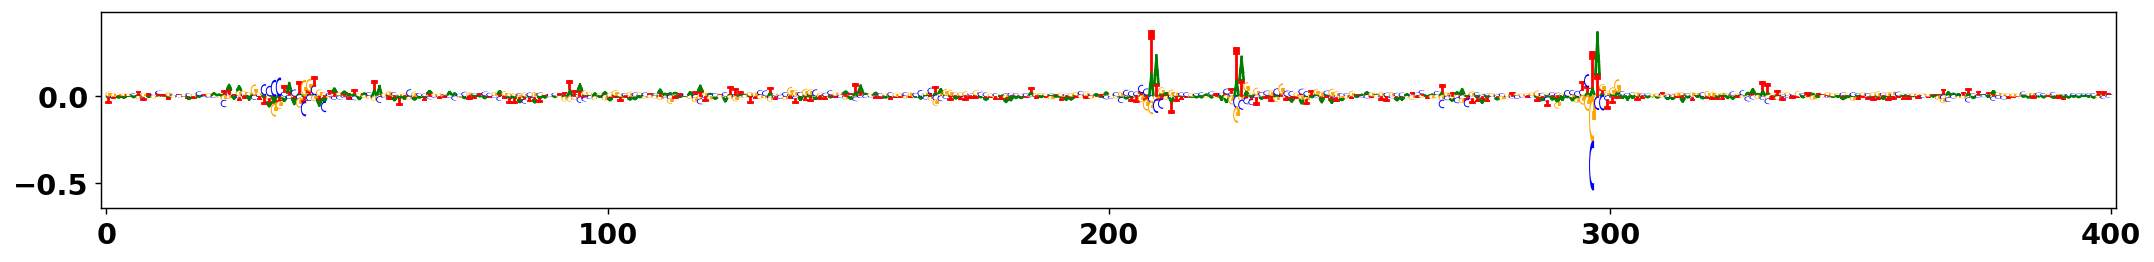

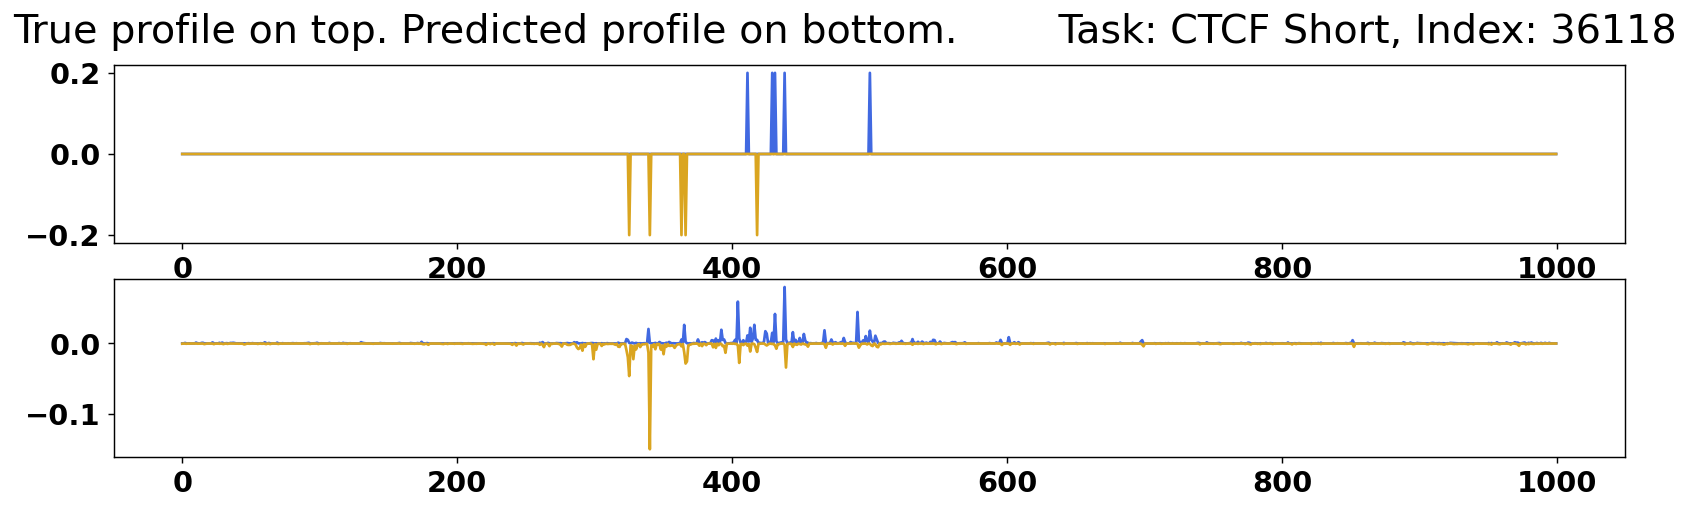

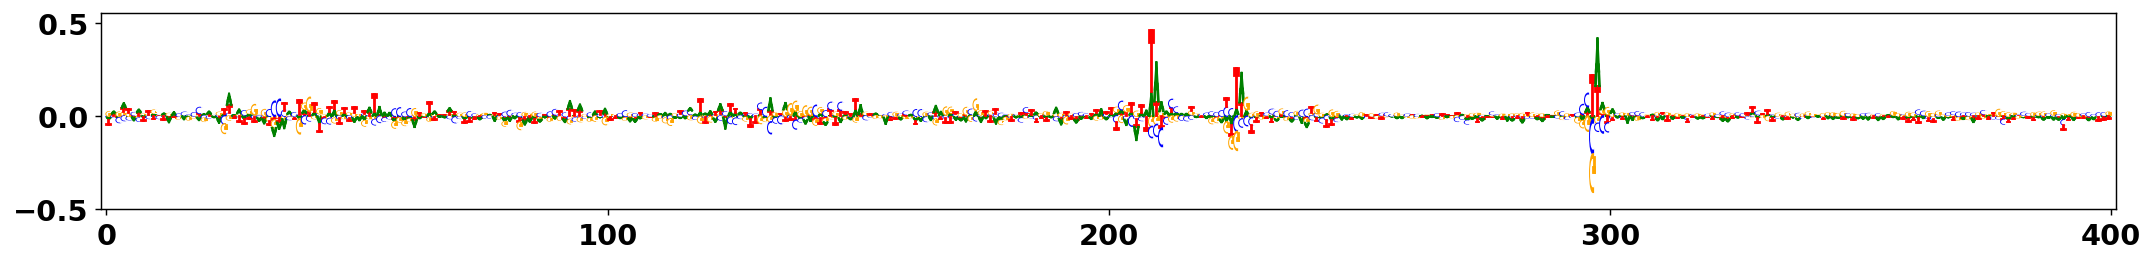

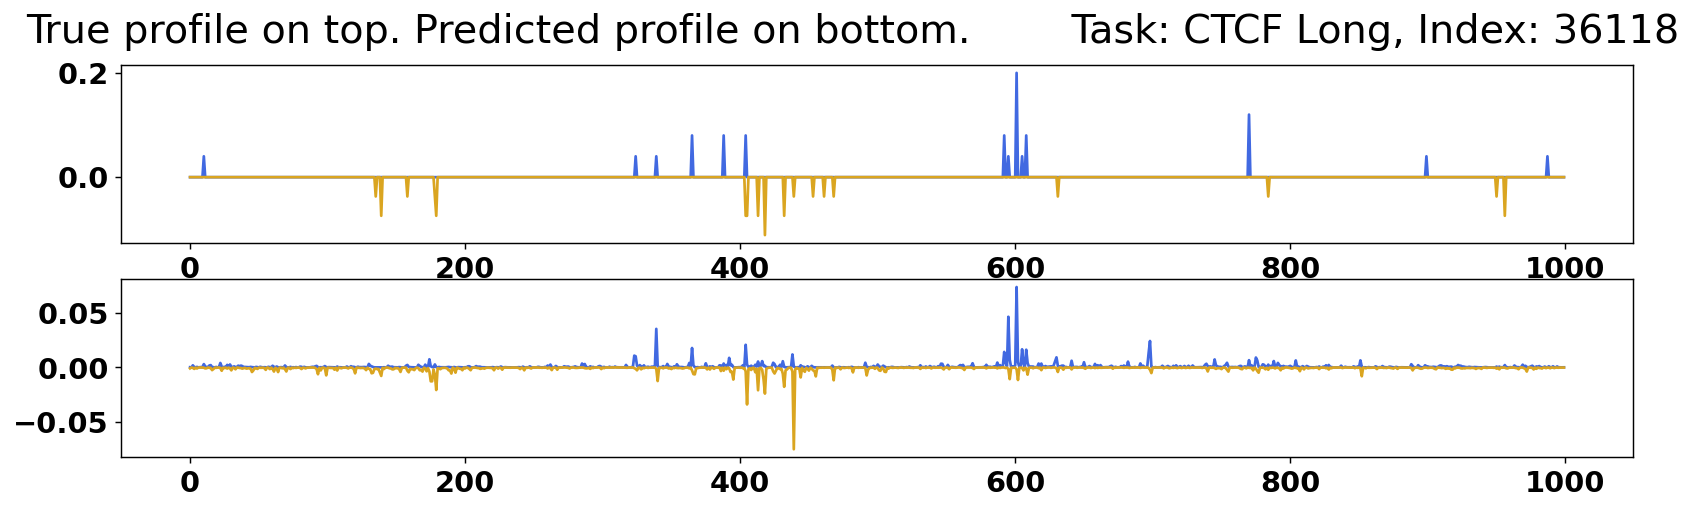

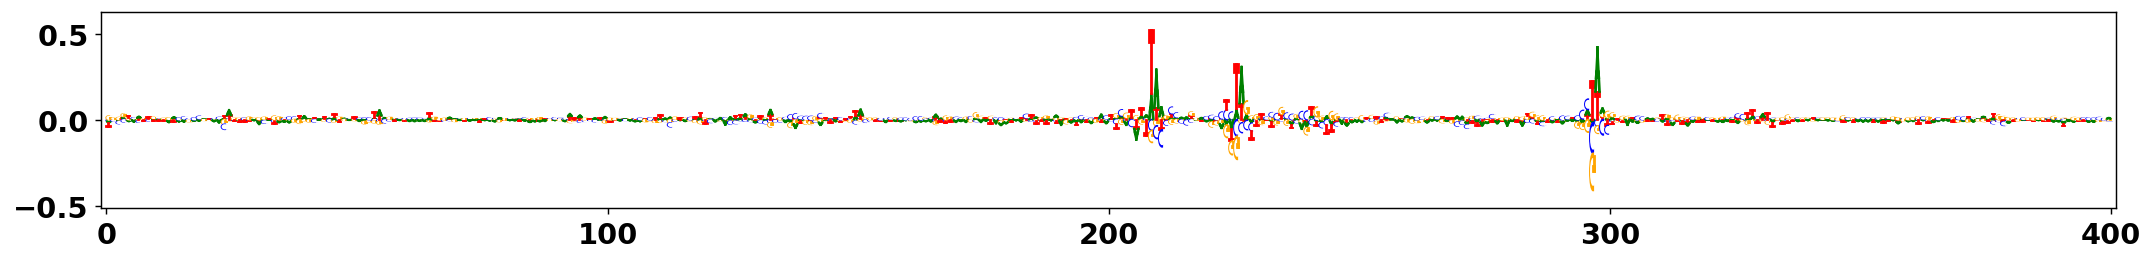

In [80]:
plot_slice = slice(int(shap_score_center_size / 4), int(3 * shap_score_center_size / 4))
# can add [plot_slice] after [INDEX] for all three

# we subtract 6 to account for the chrM contamination
for INDEX in INDEXES:
    plot(true_profs_single[~all_pred_coords_single_df.duplicated()][INDEX-6,:,:,:], 
         pred_profs_single[~all_pred_coords_single_df.duplicated()][INDEX-6,:,:,:], INDEX, task='CTCF Single-task')
    plot_weights(hyp_scores_single[~all_pred_coords_single_df.duplicated()][INDEX], subticks_frequency=100)
    
    plot(true_profs_multi[~all_pred_coords_multi_df.duplicated()][INDEX-6,0:1,:,:], 
         pred_profs_multi[~all_pred_coords_multi_df.duplicated()][INDEX-6,0:1,:,:], INDEX, task='CTCF Short')
    plot_weights(hyp_scores_short[~all_pred_coords_multi_df.duplicated()][INDEX], subticks_frequency=100)
    
    plot(true_profs_multi[~all_pred_coords_multi_df.duplicated()][INDEX-6,1:2,:,:], 
         pred_profs_multi[~all_pred_coords_multi_df.duplicated()][INDEX-6,1:2,:,:], INDEX, task='CTCF Long')
    plot_weights(hyp_scores_long[~all_pred_coords_multi_df.duplicated()][INDEX], subticks_frequency=100)
    print('\n\n\n\n\n\n\n\n')